In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ConvNeXtBase, ConvNeXtXLarge
from tensorflow.keras.layers import GlobalAveragePooling2D

Matplotlib is building the font cache; this may take a moment.


# Cleaning Corrupted Images

In [2]:
train_dir = '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images'

In [3]:
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
subdirectories

['/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/shrikhand',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/jalebi',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/biryani',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/bhindi_masala',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/imarti',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/pootharekulu',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/poha',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/doodhpak',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/sandesh',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/chapati',
 '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images/

In [4]:
import PIL
from PIL import Image
import os

In [5]:
# Identify and delete corrupted image in each of the folder file
for folder_path in subdirectories:
  for filename in os.listdir(folder_path):
      try:
          image = Image.open(os.path.join(folder_path, filename))
      except PIL.UnidentifiedImageError as e:
          print(f"Error in file {filename}: {e}")
          os.remove(os.path.join(folder_path, filename))
          print(f"Removed file {filename}")

# Creating New Images Using Augmentation For More Balanced Classes

# Creating The Dataframe

In [10]:
categories = sorted(os.listdir(train_dir))
categories = [category for category in categories if category != '.DS_Store']

categories

['adhirasam',
 'aloo_gobi',
 'aloo_matar',
 'aloo_methi',
 'aloo_shimla_mirch',
 'aloo_tikki',
 'anarsa',
 'ariselu',
 'bandar_laddu',
 'basundi',
 'bhatura',
 'bhindi_masala',
 'biryani',
 'boondi',
 'butter_chicken',
 'chak_hao_kheer',
 'cham_cham',
 'chana_masala',
 'chapati',
 'chhena_kheeri',
 'chicken_razala',
 'chicken_tikka',
 'chicken_tikka_masala',
 'chikki',
 'daal_baati_churma',
 'daal_puri',
 'dal_makhani',
 'dal_tadka',
 'dharwad_pedha',
 'doodhpak',
 'double_ka_meetha',
 'dum_aloo',
 'gajar_ka_halwa',
 'gavvalu',
 'ghevar',
 'gulab_jamun',
 'imarti',
 'jalebi',
 'kachori',
 'kadai_paneer',
 'kadhi_pakoda',
 'kajjikaya',
 'kakinada_khaja',
 'kalakand',
 'karela_bharta',
 'kofta',
 'kuzhi_paniyaram',
 'lassi',
 'ledikeni',
 'litti_chokha',
 'lyangcha',
 'maach_jhol',
 'makki_di_roti_sarson_da_saag',
 'malapua',
 'misi_roti',
 'misti_doi',
 'modak',
 'mysore_pak',
 'naan',
 'navrattan_korma',
 'palak_paneer',
 'paneer_butter_masala',
 'phirni',
 'pithe',
 'poha',
 'poornalu

In [11]:
df = pd.DataFrame(columns=['image_path', 'label'])
df

,image_path,label


In [12]:
dfs = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

The dataset shows class imbalance, where some food categories have many more samples than others. For example, "donuts" and "hamburger" have lots of samples, while "steak" or "cheesecake" have much fewer.

### Choosing A Limited Number Of Images

In [ ]:
dfs = []
max_images_per_category = 600

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    count = 0
    for image_name in os.listdir(category_path):
        if count >= max_images_per_category:
            break
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
        count += 1
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

In [13]:
df = pd.concat(dfs, ignore_index=True)
df

,image_path,label
0,/Users/davemag9/Desktop/Diploma/archive1/India...,adhirasam
1,/Users/davemag9/Desktop/Diploma/archive1/India...,adhirasam
2,/Users/davemag9/Desktop/Diploma/archive1/India...,adhirasam
3,/Users/davemag9/Desktop/Diploma/archive1/India...,adhirasam
4,/Users/davemag9/Desktop/Diploma/archive1/India...,adhirasam
...,...,...
3995,/Users/davemag9/Desktop/Diploma/archive1/India...,unni_appam
3996,/Users/davemag9/Desktop/Diploma/archive1/India...,unni_appam
3997,/Users/davemag9/Desktop/Diploma/archive1/India...,unni_appam
3998,/Users/davemag9/Desktop/Diploma/archive1/India...,unni_appam


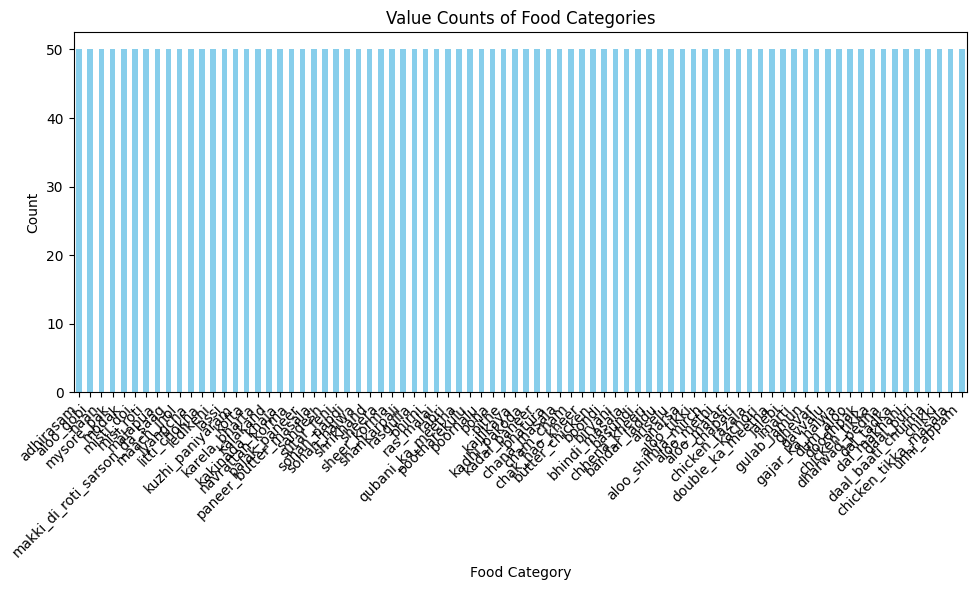

In [14]:
plt.figure(figsize=(10, 6))

df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Food Category')
plt.ylabel('Count')
plt.title('Value Counts of Food Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
df['label'].value_counts()

label
adhirasam               50
aloo_gobi               50
naan                    50
mysore_pak              50
modak                   50
                        ..
daal_puri               50
daal_baati_churma       50
chikki                  50
chicken_tikka_masala    50
unni_appam              50
Name: count, Length: 80, dtype: int64

# Computing class weights

In [16]:
labels = df['label']

In [17]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

In [18]:
class_weights_dict = dict(enumerate(class_weights))

In [19]:
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0), 6: np.float64(1.0), 7: np.float64(1.0), 8: np.float64(1.0), 9: np.float64(1.0), 10: np.float64(1.0), 11: np.float64(1.0), 12: np.float64(1.0), 13: np.float64(1.0), 14: np.float64(1.0), 15: np.float64(1.0), 16: np.float64(1.0), 17: np.float64(1.0), 18: np.float64(1.0), 19: np.float64(1.0), 20: np.float64(1.0), 21: np.float64(1.0), 22: np.float64(1.0), 23: np.float64(1.0), 24: np.float64(1.0), 25: np.float64(1.0), 26: np.float64(1.0), 27: np.float64(1.0), 28: np.float64(1.0), 29: np.float64(1.0), 30: np.float64(1.0), 31: np.float64(1.0), 32: np.float64(1.0), 33: np.float64(1.0), 34: np.float64(1.0), 35: np.float64(1.0), 36: np.float64(1.0), 37: np.float64(1.0), 38: np.float64(1.0), 39: np.float64(1.0), 40: np.float64(1.0), 41: np.float64(1.0), 42: np.float64(1.0), 43: np.float64(1.0), 44: np.float64(1.0), 45: np.float64(1.0), 46: np.float64(1.0), 47: np.

In [20]:
class_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Train_Test Split

In [21]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [22]:
train_df.shape

(3200, 2)

In [23]:
val_df.shape

(800, 2)

# Image Augmentation

In [24]:
augmentation_params = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

In [40]:
img_size = (224, 224)

In [41]:
batch_size = 32

In [42]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    **augmentation_params
)

In [43]:
val_datagen = ImageDataGenerator(
    rescale = 1./255
    )

In [44]:
train_images = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 3200 validated image filenames belonging to 80 classes.


In [45]:
val_images = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 800 validated image filenames belonging to 80 classes.


# Visualize Some Images From Different Categories

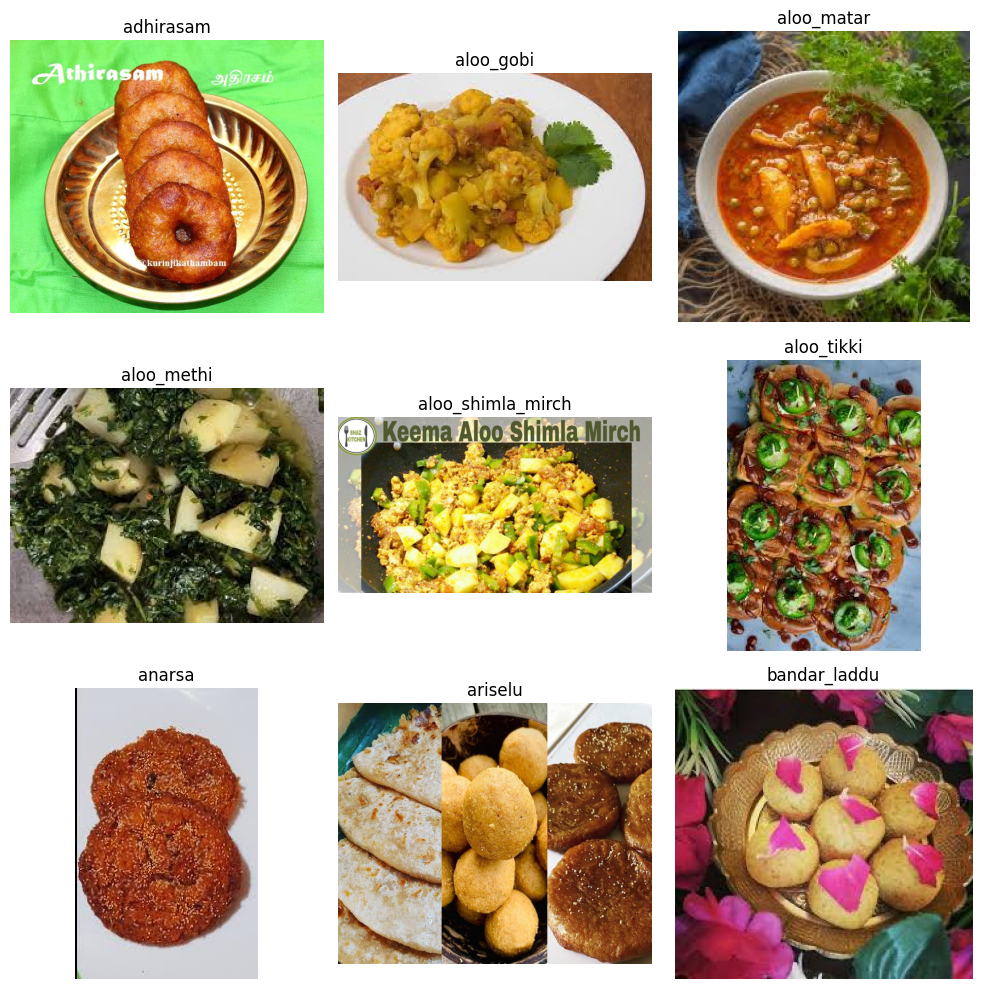

In [46]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

# Limit the loop to the first 9 categories or however many subplots you have
for i, category in enumerate(categories[:9]):
    category_df = train_df[train_df['label'] == category]
    image_path = category_df.iloc[10]['image_path']
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


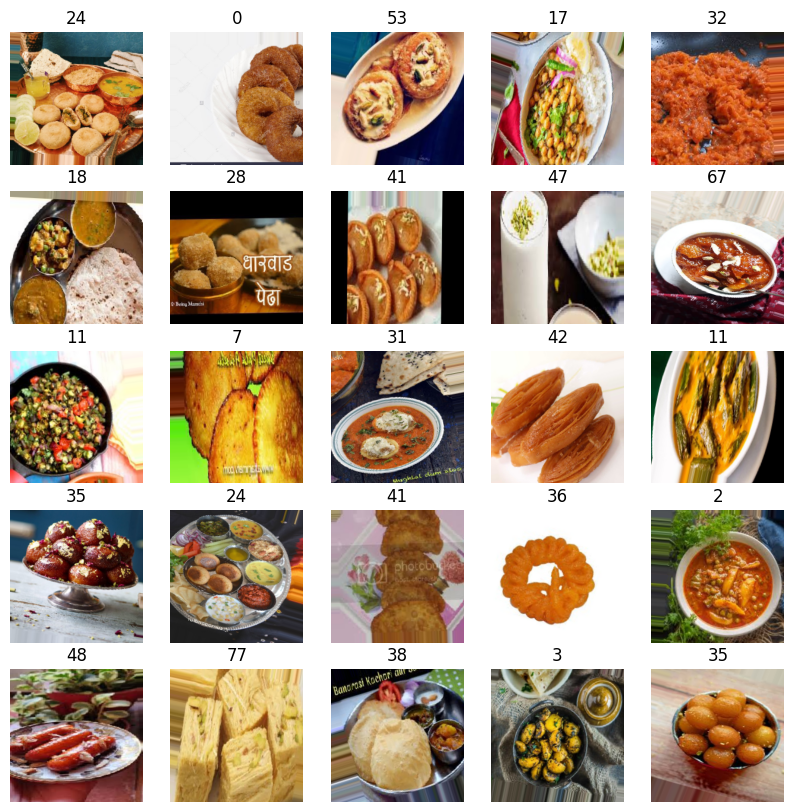

In [47]:
batch_train_images, batch_train_labels = next(train_images)

class_names = np.argmax(batch_train_labels, axis=1)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(batch_train_images[i])
    plt.title(class_names[i])
    plt.axis('off')
plt.show()

# VGG MODEL (62%)

### Model

In [51]:
from tensorflow.keras.applications import VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

for layer in vgg_model.layers:
    layer.trainable = False

x = Flatten()(vgg_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=vgg_model.input, outputs=predictions, name='VGG16')

model.summary()

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_images,
                    steps_per_epoch=train_images.samples // batch_size,
                    epochs=10,
                    validation_data=val_images,
                    validation_steps=val_images.samples // batch_size)

Epoch 1/10
602/602 [==============================] - 305s 505ms/step - loss: 2.0565 - accuracy: 0.4228 - val_loss: 1.5870 - val_accuracy: 0.5356
Epoch 2/10
602/602 [==============================] - 303s 503ms/step - loss: 1.4944 - accuracy: 0.5543 - val_loss: 1.3745 - val_accuracy: 0.6000
Epoch 3/10
602/602 [==============================] - 287s 477ms/step - loss: 1.3536 - accuracy: 0.5959 - val_loss: 1.4016 - val_accuracy: 0.5923
Epoch 4/10
602/602 [==============================] - 286s 474ms/step - loss: 1.2662 - accuracy: 0.6199 - val_loss: 1.3292 - val_accuracy: 0.6121
Epoch 5/10
602/602 [==============================] - 306s 509ms/step - loss: 1.1998 - accuracy: 0.6411 - val_loss: 1.3842 - val_accuracy: 0.6027
Epoch 6/10
602/602 [==============================] - 306s 507ms/step - loss: 1.1630 - accuracy: 0.6462 - val_loss: 1.3169 - val_accuracy: 0.6200
Epoch 7/10
602/602 [==============================] - 290s 482ms/step - loss: 1.1309 - accuracy: 0.6554 - val_loss: 1.3412 -

In [ ]:
model.save('/content/models/vgg16', save_format='tf')

### History Plot

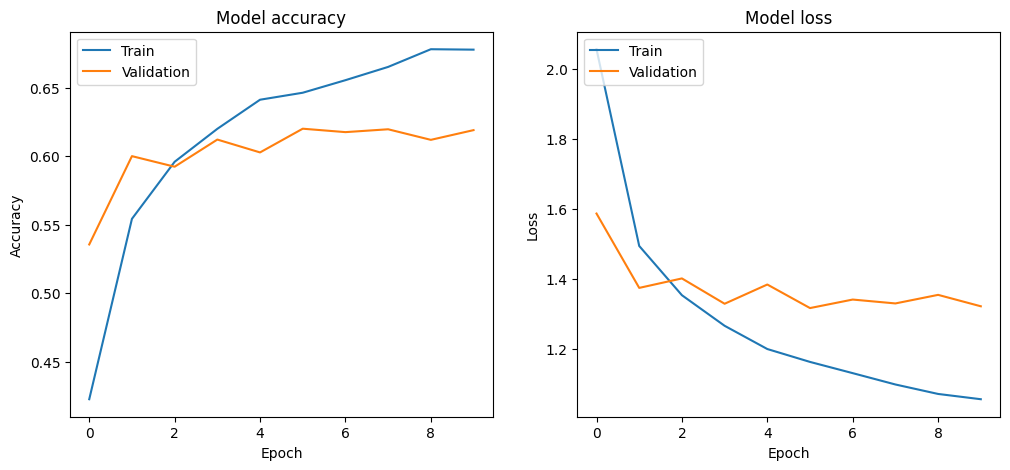

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# MobileNet MODEL (83%)

### Model

In [ ]:
pretrained_model = MobileNetV2(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

# x = Dense(8, activation='relu')(pretrained_model.output)
# x = Dense(16, activation='relu')(x)
outputs = Dense(len(categories), activation='softmax')(pretrained_model.output)

model_mn = Model(pretrained_model.input, outputs, name='MobileNetV2')

# print(model_mn.summary())

In [ ]:
model_mn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    sample_weight_mode=class_weights
)

### Loading Pre-trained Model

In [ ]:
model_mn = load_model('/content/MobileNet_V2.h5')

In [ ]:
history_mn = model_mn.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
330/330 [==============================] - 147s 444ms/step - loss: 0.8065 - accuracy: 0.7613 - val_loss: 0.9036 - val_accuracy: 0.7295
Epoch 2/5
330/330 [==============================] - 142s 431ms/step - loss: 0.7495 - accuracy: 0.7743 - val_loss: 0.8875 - val_accuracy: 0.7367
Epoch 3/5
330/330 [==============================] - 147s 445ms/step - loss: 0.7093 - accuracy: 0.7827 - val_loss: 0.8519 - val_accuracy: 0.7477
Epoch 4/5
330/330 [==============================] - 142s 430ms/step - loss: 0.6790 - accuracy: 0.7909 - val_loss: 0.8678 - val_accuracy: 0.7477


In [ ]:
# model_mn.save('/content/models/MobileNet_V3.h5', save_format='h5')

### Validation data Evaluation

In [ ]:
val_loss_mn, val_acc_mn = model_mn.evaluate(val_images, verbose=0)

In [ ]:
val_loss_mn

0.5274724960327148

In [ ]:
val_acc_mn

0.8349595069885254

In [ ]:
predictions = model_mn.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_classes[:26]

151/151 [==============================] - 17s 113ms/step


array([ 7,  7,  5,  3,  8, 19, 17, 16,  5,  5, 18,  5,  5, 13, 16,  5,  8,
       13,  7, 12,  5, 13,  0,  5, 19, 19])

In [ ]:
true_classes = val_images.classes

In [ ]:
class_labels = list(val_images.class_indices.keys())

In [ ]:
num_images = 25
count = 0

while count < num_images:
    print(f"{count + 1}. Label: {true_classes[count]}, Prediction: {predicted_classes[count]}")
    count += 1

1. Label: 8, Prediction: 7
2. Label: 7, Prediction: 7
3. Label: 5, Prediction: 5
4. Label: 3, Prediction: 3
5. Label: 8, Prediction: 8
6. Label: 19, Prediction: 19
7. Label: 17, Prediction: 17
8. Label: 16, Prediction: 16
9. Label: 1, Prediction: 5
10. Label: 5, Prediction: 5
11. Label: 18, Prediction: 18
12. Label: 5, Prediction: 5
13. Label: 5, Prediction: 5
14. Label: 13, Prediction: 13
15. Label: 21, Prediction: 16
16. Label: 5, Prediction: 5
17. Label: 8, Prediction: 8
18. Label: 13, Prediction: 13
19. Label: 7, Prediction: 7
20. Label: 12, Prediction: 12
21. Label: 0, Prediction: 5
22. Label: 13, Prediction: 13
23. Label: 0, Prediction: 0
24. Label: 5, Prediction: 5
25. Label: 19, Prediction: 19


### Confusion Matrix

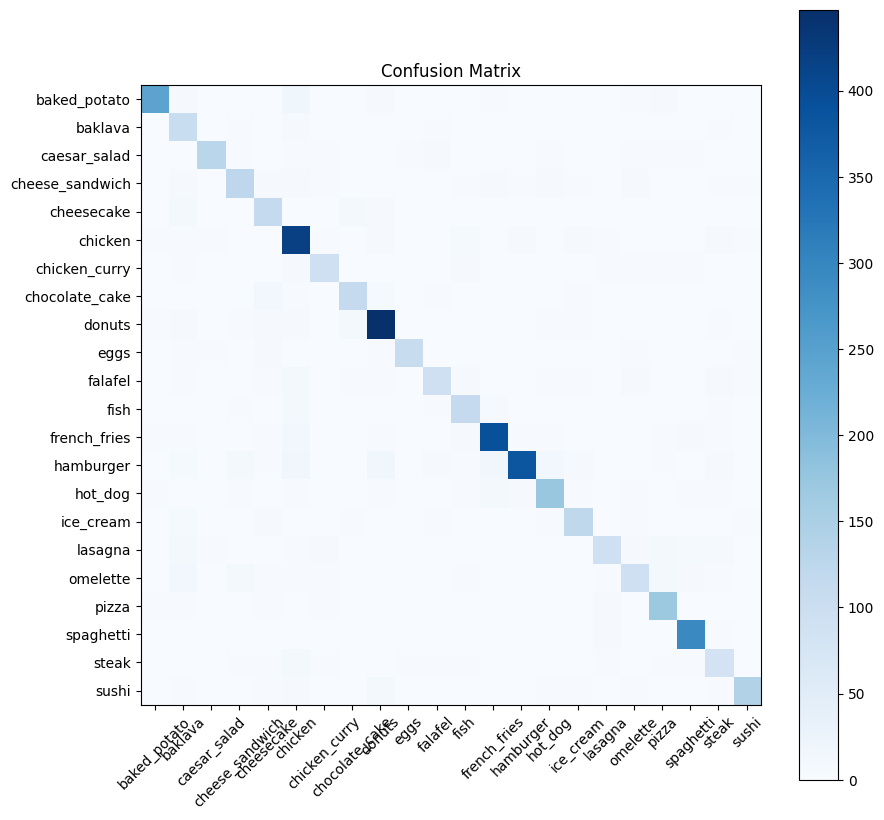

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.show()

### Classification Report

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                 precision    recall  f1-score   support

   baked_potato       0.95      0.85      0.90       286
        baklava       0.59      0.87      0.71       120
   caesar_salad       0.91      0.82      0.86       158
cheese_sandwich       0.79      0.74      0.76       167
     cheesecake       0.71      0.79      0.75       141
        chicken       0.79      0.90      0.85       462
  chicken_curry       0.78      0.79      0.78       115
 chocolate_cake       0.82      0.80      0.81       141
         donuts       0.88      0.92      0.90       485
           eggs       0.91      0.82      0.86       128
        falafel       0.76      0.67      0.71       136
           fish       0.77      0.80      0.78       141
   french_fries       0.91      0.89      0.90       441
      hamburger       0.95      0.80      0.87       476
        hot_dog       0.82      0.82      0.82       211
      ice_cream       0.82      0.80      0.81       152
        lasagna       0.77    

# ConvNeXtBase MODEL (55%)

### Model

In [ ]:
pretrained_model = ConvNeXtBase(weights='imagenet',
                             include_top=False,
                             input_shape=(img_size[0], img_size[1], 3))

pretrained_model.trainable = False

x = GlobalAveragePooling2D()(pretrained_model.output)
# x = Dense(128, activation='relu')(x)
# x = Dense(32, activation='relu')(x)
outputs = Dense(len(categories), activation='softmax')(x)

model_convnext_pretrained = Model(pretrained_model.input, outputs, name='ConvNeXtBase')

In [ ]:
model_convnext_pretrained.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_convnext_pretrained = model_convnext_pretrained.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
330/330 [==============================] - 299s 838ms/step - loss: 2.5527 - accuracy: 0.3000 - val_loss: 2.0861 - val_accuracy: 0.4367
Epoch 2/5
330/330 [==============================] - 265s 802ms/step - loss: 2.0381 - accuracy: 0.4473 - val_loss: 1.8122 - val_accuracy: 0.5083
Epoch 3/5
330/330 [==============================] - 267s 808ms/step - loss: 1.8571 - accuracy: 0.4844 - val_loss: 1.7069 - val_accuracy: 0.5242
Epoch 4/5
330/330 [==============================] - 303s 917ms/step - loss: 1.7575 - accuracy: 0.5074 - val_loss: 1.6151 - val_accuracy: 0.5424
Epoch 5/5
330/330 [==============================] - 266s 807ms/step - loss: 1.6908 - accuracy: 0.5200 - val_loss: 1.5788 - val_accuracy: 0.5568


# InceptionV3 MODEL (79%)

### Model

In [ ]:
from tensorflow.keras.applications import InceptionV3

pretrained_model = InceptionV3(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

outputs = Dense(len(categories), activation='softmax')(pretrained_model.output)

model_inception = Model(pretrained_model.input, outputs, name='InceptionV3')

# print(model_inception.summary())

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
model_inception.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Loading Pre-trained Model

In [ ]:
model_inception = load_model('/content/InceptionNetV3-m2.h5')

In [ ]:
history_inception = model_inception.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
 782/1147 [===================>..........] - ETA: 2:37 - loss: 0.9229 - accuracy: 0.7224

In [ ]:
model_inception.save('/content/models/InceptionNetV3.h5', save_format='h5')

### History Plot

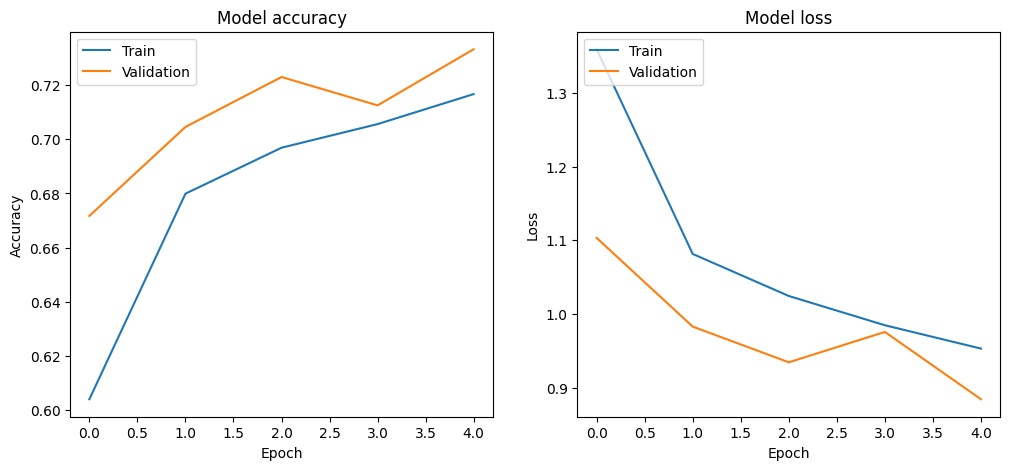

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
predictions = model_inception.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_classes

151/151 [==============================] - 20s 105ms/step


array([ 8,  7,  5, ..., 21, 14, 13])

In [ ]:
true_classes = val_images.classes

In [ ]:
class_labels = list(val_images.class_indices.keys())

### Classification Report

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                 precision    recall  f1-score   support

   baked_potato       0.90      0.80      0.85       286
        baklava       0.90      0.68      0.78       120
   caesar_salad       0.92      0.80      0.86       158
cheese_sandwich       0.78      0.62      0.69       167
     cheesecake       0.71      0.81      0.76       141
        chicken       0.87      0.82      0.84       462
  chicken_curry       0.76      0.69      0.72       115
 chocolate_cake       0.88      0.70      0.78       141
         donuts       0.91      0.88      0.90       485
           eggs       0.68      0.93      0.79       128
        falafel       0.53      0.83      0.64       136
           fish       0.46      0.87      0.60       141
   french_fries       0.94      0.81      0.87       441
      hamburger       0.96      0.67      0.79       476
        hot_dog       0.79      0.76      0.77       211
      ice_cream       0.71      0.84      0.77       152
        lasagna       0.55    

### Validation data Evaluation

In [ ]:
val_loss_in, val_acc_in = model_inception.evaluate(val_images, verbose=0)

In [ ]:
val_loss_in

0.7039835453033447

In [ ]:
val_acc_in

0.7907411456108093

# ConvNext XLarge MODEL (64%)

### Model

In [ ]:
pretrained_model_large = ConvNeXtXLarge(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

pretrained_model_large.trainable = False


x = GlobalAveragePooling2D()(pretrained_model_large.output)
x = Dense(8192, activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
outputs = Dense(len(categories), activation='softmax')(x)

model_conv = Model(pretrained_model_large.input, outputs, name='ConvNeXtLarge')

In [ ]:
model_conv.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
history_conv = model_conv.fit(
    train_images,
    validation_data=val_images,
    epochs=2,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/2
1148/1148 [==============================] - 2308s 2s/step - loss: 1.5152 - accuracy: 0.5706 - val_loss: 1.2779 - val_accuracy: 0.6368
Epoch 2/2
1148/1148 [==============================] - 2265s 2s/step - loss: 1.3239 - accuracy: 0.6365 - val_loss: 1.2200 - val_accuracy: 0.6462


In [ ]:
model_conv.save('/content/models/ConvNext1.h5', save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Building Evaluation Dataframe For Test Data

### Loading MobileNet Model

In [ ]:
model_mn = load_model('/content/MobileNet_V2.h5')

### Loading Inception Model

In [ ]:
model_inception = load_model('/content/InceptionNetV3-m2.h5')

### q1_submission.csv

In [ ]:
import zipfile

zip_file_path = '/test.zip'
extract_dir = '/content/test/test'

if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

In [ ]:
test_dir = '/content/test'

In [ ]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
    )

In [ ]:
img_size = (224, 224)

In [ ]:
batch_size = 32

In [ ]:
test_images = test_datagen.flow_from_directory(
    test_dir,

    target_size=img_size,
    batch_size=batch_size,

    class_mode=None,
    shuffle=False
)

In [ ]:
predictions = model_mn.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
predicted_classes

In [ ]:
class_labels = list(val_images.class_indices.keys())

In [ ]:
predicted_categories = [class_labels[idx] for idx in predicted_classes]

In [ ]:
submission_df = pd.DataFrame({'name': test_images.filenames, 'predicted': predicted_categories})

In [ ]:
submission_df.head()

In [ ]:
submission_df.to_csv('q1_submission.csv', index=False)